# Latent-Dirichlet Allocation for Filtering Blog Posts

This dataset contains 36,982 individual blog posts from 5 different financial blog sites: Calculated Risk, Naked Capitalism, Grasping Reality, Marginal Revolution, and Cafe Hayek. The blog, title, date of publication, author, text are provided for each post. However, each blog contains posts that are unrelated to our research interests, including movie reviews, travel plans, etc. Filtering out by keywords poses a high risk of false negatives and positives, and it would be difficult to create our own dictionary that encapsulates every topic of interest.

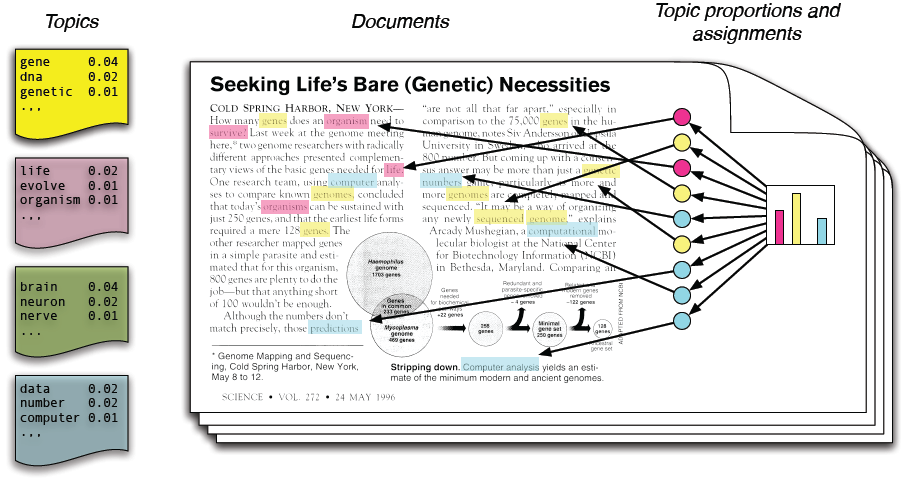

Through the use of Latent-Dirichlet Allocation (LDA), an unsupervised method of drawing topics out of a collection of texts, we can achieve a more accurate method of filtering the posts. By extracting X number of topics mentioned across all blog posts (examined one blog at a time), we are able to identify unrelated topics and remove blogs that are classified within these topics. The algorithm allows the user to tweak the number of topics generated to find the optimal coverage of the text. We will be using the Gensim wrapper of Mallet's LDA algorithm for this analysis.

Preprocessing and LDA implementation adapted from [Selva Prabhakaran's blog](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)


<b>The technical write-ups related to this dataset:</b>

[Webscraping] (Coming Soon)

[Sentiment Analysis] (Coming Soon)

<b>My analysis and findings:</b>

[Sentiment Analysis] (Coming Soon)

[Blog Comparison] (Coming Soon)

In [1]:
import re
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy for lemmatization
import spacy

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Mallet storage location
mallet_path = 'path/mallet-2.0.8/bin/mallet'

<h2>Initial Observations</h2>

In [3]:
df = pd.read_csv('path/file_name.csv', index_col=0)
df.dropna(inplace=True)
df

,title,date,author,text,blog
1,The General Fund Deficit,2005-01-08,Calculated Risk,Dr. DeLong does an outstanding job with his po...,Calculated Risk
2,At last! Sunshine in California,2005-01-12,Calculated Risk,A beautiful day in Yosemite! Photo captured...,Calculated Risk
3,Housing Prices: An asset bubble?,2005-01-11,Calculated Risk,Here is a look at the period from Jan 1998 unt...,Calculated Risk
4,"Jobs, Jobs, Jobs",2005-01-13,Calculated Risk,An interesting post on macroblog started me th...,Calculated Risk
5,NYTimes on Social Security: A Question of Numbers,2005-01-18,Calculated Risk,This article by Roger Lowenstein is excellent....,Calculated Risk
...,...,...,...,...,...
36091,Looting,2009-12-01,Russ Roberts,They are stealing our money. They are then was...,Cafe Hayek
36092,Tierney on Climategate,2009-12-01,Russ Roberts,Tierney gives a nice summary (HT: Maggie’s Far...,Cafe Hayek
36093,If only wishing would make it so,2009-12-01,Russ Roberts,"The AP reports: Sen. John McCain, R-Ariz., att...",Cafe Hayek
36094,Playing with fire,2009-12-01,Russ Roberts,James Hamilton thoughtfully lays out (HT: Brad...,Cafe Hayek


<h3>Keyword Title Search</h3>

While using the keyword search was deemed unreliable for the main filtering process, it does allow us to immediately filter out obviously-unrelated posts. By manually looking through the dataset, indicators of these posts included titles referring to "assorted links" and lecture materials. From these titles, a list of remove_words was generated to filter out such posts. This process also checked for NA's, and in total removed 2,081 posts from the dataset.

In [4]:
remove_words = ['links', 'economics 113', 'econ 113', 'econ 115', 
                'economics 115', 'economics 101b', 'econ 101b',
                'econ 202b', 'lecture']

for i, row in df.iterrows():
    if any(word in row['title'].lower() for word in remove_words):
        df.drop(index=i, axis=0, inplace=True)

<h2>Building the Model</h2>

While the LDA can accurately generate topics from a collection of texts, each blog has its own unique set of topics, writing style, and language. To prevent the model from extracting topics based on the differences between the blogs rather than the content, the filtering process was performed individually on each blog. This allowed the model to more accurately encapsulate the unique content of each site.

The differences in grouping and number of topics for each blogg did not impact this analysis because we were solely looking to filter out unrelated blogs. In other cases, such as measuring topic evolution over time, topic consistency would be important in anchoring the comparison between blogs.

For this demonstration of the filtering process, I used the Marginal Revolution blog. However, this process was repeated for each blog individually.

In [5]:
blog_name = "Marginal Revolution"
blog = df[df.blog.eq(blog_name)]

<h2>Text Preprocessing</h2>

<h3>Cleaning Text</h3>

The use of regular expressions allowed for the removal of urls, weird/foreign characters, and general html elements. 

Further explanation and application of regular expressions can be found [here](https://www.regular-expressions.info/).

In [7]:
data = blog.text.values.tolist()

# Remove urls
data = [re.sub("http[^[:space:]]*", "", sent) for sent in data]

# Remove weird characters
data = [re.sub("[^a-zA-Z]+", " ", sent) for sent in data]

# Remove html elements
data = [re.sub("<.*?>", " ", sent) for sent in data]

print(data[0])

# Add clean text back into individual blog df for future joining
blog['clean'] = data

['Elizabeth Anderson and other commentators misunderstand Hayek and in the process they fail to understand the sense in which market outcomes may be said to be just Tyler comments also Hayek argued that the concept of social or distributive justice was empty and meaningless Anderson tries to use this argument which she explains well to suggest that any idea of libertarian or free market justice must also be empty and meaningless Hayek however did not argue against rules of just conduct those end independent rules which serve the formation of a spontaneous order Among such rules may be Nozickian or Lockean rules of voluntary exchange It s quite possible for example to be a good Hayekian and also to say that I deserve my income because it was acquired by just conduct e g by production and trade True it is an accidental fact that I live in a time and place where my skills are highly prized In this sense I do not deserve my income i e my income is in part a function of things beyond my con

<h3>Tokenization</h3>

Tokenization splits each post into individual pieces, called tokens. 

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

print(data_words[0])

['elizabeth', 'anderson', 'and', 'other', 'commentators', 'misunderstand', 'hayek', 'and', 'in', 'the', 'process', 'they', 'fail', 'to', 'understand', 'the', 'sense', 'in', 'which', 'market', 'outcomes', 'may', 'be', 'said', 'to', 'be', 'just', 'tyler', 'comments', 'also', 'hayek', 'argued', 'that', 'the', 'concept', 'of', 'social', 'or', 'distributive', 'justice', 'was', 'empty', 'and', 'meaningless', 'anderson', 'tries', 'to', 'use', 'this', 'argument', 'which', 'she', 'explains', 'well', 'to', 'suggest', 'that', 'any', 'idea', 'of', 'libertarian', 'or', 'free', 'market', 'justice', 'must', 'also', 'be', 'empty', 'and', 'meaningless', 'hayek', 'however', 'did', 'not', 'argue', 'against', 'rules', 'of', 'just', 'conduct', 'those', 'end', 'independent', 'rules', 'which', 'serve', 'the', 'formation', 'of', 'spontaneous', 'order', 'among', 'such', 'rules', 'may', 'be', 'nozickian', 'or', 'lockean', 'rules', 'of', 'voluntary', 'exchange', 'it', 'quite', 'possible', 'for', 'example', 'to',

<h3>Removing Stopwords, Recognizing Bigrams/Trigrams, and Lemmatization</h3>

<b>Stopword Removal:</b> Stopwords are commonly used words, including "the", "a", and "an", that are removed before search or processing.

<b>Bigrams/Trigrams:</b> Words that appeared often together were grouped into bigrams and trigrams to indicate multi-word pronouns or compound words. Instead of looking at Marginal Revolution as 'marginal', and 'revolution', the bigram model will convert these into 'marginal_revolution'. This prevented each word from being used out of context.

<b>Lemmatization:</b> Lemmatization refers to grouping together the different inflections of a word into to its base form, or <i>lemma</i>. For example, "rocks" = "rock" and "better" = "good". The Python library spacy was used lemmatize each body of text.

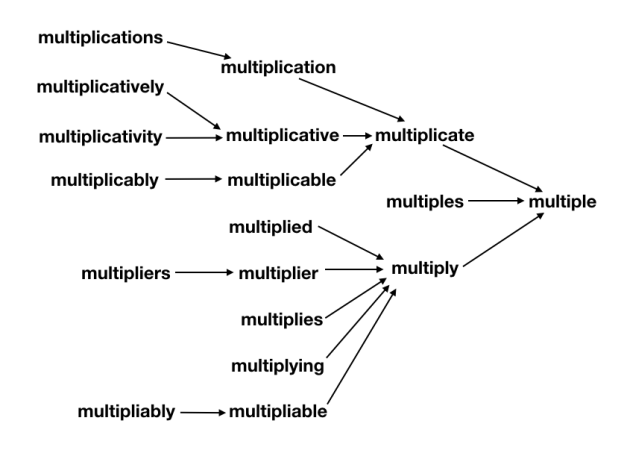

The preprocessing minimized the amount of noise in the text before the corpus and dictionary are generated.

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# =============================================================================
# Calling the functions from above:
# =============================================================================
    
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model
nlp = spacy.load('en', disable=['parser', 'ner'])

# Lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[0])

['commentator', 'process', 'fail', 'understand', 'sense', 'market', 'outcome', 'may', 'say', 'tyler', 'comment', 'also', 'argue', 'concept', 'social', 'distributive', 'justice', 'empty', 'try', 'argument', 'explain', 'well', 'suggest', 'idea', 'libertarian', 'justice', 'must', 'also', 'empty', 'meaningless', 'hayek', 'however', 'argue', 'rule', 'conduct', 'end', 'independent', 'rule', 'serve', 'formation', 'rule', 'may', 'nozickian', 'rule', 'voluntary', 'exchange', 'quite', 'possible', 'example', 'good', 'hayekian', 'also', 'say', 'deserve', 'income', 'acquire', 'conduct', 'production', 'trade', 'true', 'accidental', 'fact', 'live', 'time', 'place', 'skill', 'highly', 'prize', 'sense', 'deserve', 'income', 'income', 'part', 'function', 'thing', 'control', 'deserve', 'income', 'sense', 'acquire', 'justly', 'take', 'justly', 'acquire', 'earning', 'may', 'injustice']


<h2>Dictionary and Corpus</h2>

The collection of all unique words within the blog formed the dictionary, which was then converted into machine-readable format. The collection of text in a machine-readable format is known as the corpus, and acts as a representative sample of the language used by each blog. We generated our own corpus due to the need for specified topics based on the content of each blog.

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[0])

[(0, 1), (1, 3), (2, 3), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 3), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 4), (29, 1), (30, 1), (31, 2), (32, 2), (33, 1), (34, 1), (35, 1), (36, 3), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 4), (49, 2), (50, 3), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)]


<h2>Model Testing and Evaluation</h2>

The fundamental goal of the topic model is to tell a story to a human. Therefore, the only way to truly measure the validity of a topic model is to measure if it makes sense to a human. However, I used coherence values to focus my manual evaluation of each model.

The compute_coherence_values function trained 15 models with every value of k (number of topics) from 2-30 and recorded the coherence for each. This function alone did not determine the number of topics I used in my optimal model, but rather gave me an idea of the range of k values to look into manually.

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#%% Call coherence function

model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2, limit=30, 
                                                        step=2)

<h3>Coherence Evaluation</h3>

Topic coherence measures the degree of semantic similarity between high-scoring words within topics. From the coherence values, I will look to see where the values first tend to level off. This point, in theory, would provide the most coherent clusters with the least amount of topics. However, coherence can only go so far in measuring how much it makes sense to a human. As previously mentioned, this value was used to get an idea as to where to begin manually evaluating the performance of each model.

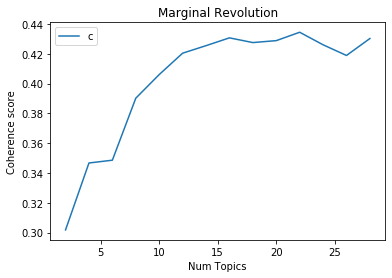

Num Topics = 2  has Coherence Value of 0.3018
Num Topics = 4  has Coherence Value of 0.3467
Num Topics = 6  has Coherence Value of 0.3486
Num Topics = 8  has Coherence Value of 0.3902
Num Topics = 10  has Coherence Value of 0.4061
Num Topics = 12  has Coherence Value of 0.4204
Num Topics = 14  has Coherence Value of 0.4255
Num Topics = 16  has Coherence Value of 0.4307
Num Topics = 18  has Coherence Value of 0.4276
Num Topics = 20  has Coherence Value of 0.4289
Num Topics = 22  has Coherence Value of 0.4345
Num Topics = 24  has Coherence Value of 0.4261
Num Topics = 26  has Coherence Value of 0.4189
Num Topics = 28  has Coherence Value of 0.4303


In [18]:
# Graph coherence value against k
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title(blog_name)
plt.savefig('Coherence Scores LDA Filter/' + blog_name + '.png')
plt.show()


# Print coherence values of each model
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

<h3>Manual Evaluation</h3>

The coherence values started to level off around k=16, so I selected a group of models around this value of k and evaluated each of these models manually. Given that I had read through a large number of the blogs from each site, I had a pretty good idea of the topics that I should be seeing. 

None of the models for any blog or any value of k extracted perfect topics. However, looking at the grouping below, you can make out the unrelated topics fairly easily: Topic 0 refered to food/city/music reviews, Topic 9 book/blog reviews, and Topic 15 general commentary on women, sex and family. However, not all topics were clearly represented by their keywords and no topics were immediately classified as unrelated/related. Before finalizing the selection, the model was used to classify each blog into their corresponding topics (as shown in blog post classification), and I manually evaluated the relation of each topic/post combination to finance, banking, and economics.

In [19]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.043*"good" + 0.017*"music" + 0.016*"food" + 0.016*"movie" + '
  '0.012*"favorite" + 0.011*"eat" + 0.010*"art" + 0.010*"restaurant" + '
  '0.007*"pick" + 0.007*"place"'),
 (1,
  '0.022*"day" + 0.018*"city" + 0.016*"home" + 0.011*"hour" + 0.010*"car" + '
  '0.010*"call" + 0.010*"water" + 0.009*"area" + 0.009*"work" + 0.009*"small"'),
 (2,
  '0.028*"view" + 0.023*"policy" + 0.022*"point" + 0.019*"issue" + '
  '0.019*"idea" + 0.018*"argument" + 0.015*"good" + 0.014*"claim" + '
  '0.013*"bad" + 0.012*"question"'),
 (3,
  '0.045*"people" + 0.028*"life" + 0.022*"child" + 0.017*"live" + '
  '0.015*"human" + 0.013*"age" + 0.013*"family" + 0.011*"die" + 0.010*"learn" '
  '+ 0.010*"world"'),
 (4,
  '0.021*"time" + 0.019*"make" + 0.016*"lot" + 0.015*"play" + 0.015*"game" + '
  '0.014*"story" + 0.013*"call" + 0.012*"give" + 0.011*"word" + 0.011*"put"'),
 (5,
  '0.048*"year" + 0.022*"report" + 0.020*"pointer" + 0.020*"find" + '
  '0.018*"study" + 0.017*"student" + 0.016*"number" + 0.015*"r

<h2>Finalizing the Dataset</h2>

<h3>Blog Post Classification</h3>

The topic model could then be used to classify each post from the original Marginal Revolution dataframe. A new dataset was created, and the post's topic, related keywords, and percent contribution were stored in the adjacent cells.

In [20]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), 
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format dataframe and select columns
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'topic', 'perc_contribution', 'Keywords', 'clean']
df_topic_text = df_dominant_topic[['clean', 'topic', 'perc_contribution']]

df_topic_text

,clean,topic,perc_contribution
0,Elizabeth Anderson and other commentators misu...,2.0,0.1581
1,Here is part of Anderson s argument Let s cons...,6.0,0.2114
2,in the Field Position Auction proposal we sub...,4.0,0.2881
3,Robert Shiller has a new edition of Irrational...,11.0,0.2181
4,Stephen Moore writes The central idea behind t...,14.0,0.3039
...,...,...,...
7644,Somali pirates are raising money through a loc...,1.0,0.1292
7645,Austrian term structure of capital paradox hig...,8.0,0.1113
7646,This book represents an attempt to explore the...,9.0,0.1273
7647,Would you like to buy an indoor ski resort in ...,11.0,0.2343


Complete this process with the remaining blogs.

<h3>Merging All Blogs</h3>

Now that we have two dataframes–one with topic values and one with the post's title, author, and blog–we are going to join these two by a similar column: the clean text. The dataframes are left-joined onto the original dataset. Left-joining preserves the author, title, date, and blog information of the original dataframe while appending the newly generated information from the LDA model onto the existing rows.

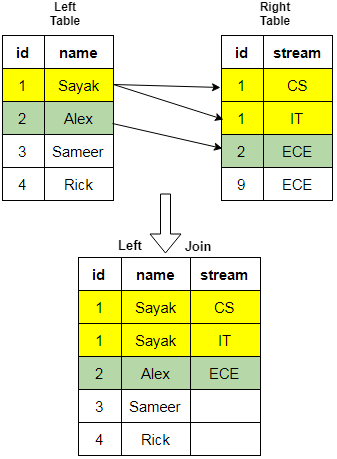

In [21]:
blog_topic = pd.merge(blog, df_topic_text, on='clean', how='left')
blog_topic.drop_duplicates(subset=['text', 'date', 'title'], inplace=True)
blog_topic.dropna(inplace=True)
blog_topic.reset_index(drop=True, inplace=True)

blog_topic

# Write dataframe to csv
blog_topic.to_csv(r'/path/file_filtered.csv')

,title,date,author,text,blog,clean,topic,perc_contribution
0,Rules of Just Conduct versus Social Justice,2005-01-31,Alex Tabarrok,Elizabeth Anderson and other commentators misu...,Marginal Revolution,Elizabeth Anderson and other commentators misu...,2.0,0.1581
1,Do people deserve their market prices and wages?,2005-01-31,Tyler Cowen,Here is part of Anderson’s argument:Let’s cons...,Marginal Revolution,Here is part of Anderson s argument Let s cons...,6.0,0.2114
2,Markets for football possessions,2005-01-31,Tyler Cowen,"…[in] the ""Field Position Auction"" proposal we...",Marginal Revolution,in the Field Position Auction proposal we sub...,4.0,0.2881
3,Shiller on Housing Prices,2005-01-28,Alex Tabarrok,Robert Shiller has a new edition of Irrational...,Marginal Revolution,Robert Shiller has a new edition of Irrational...,11.0,0.2181
4,Should you have an option on a flat tax?,2005-01-31,Tyler Cowen,Stephen Moore writes:The central idea behind t...,Marginal Revolution,Stephen Moore writes The central idea behind t...,14.0,0.3039
...,...,...,...,...,...,...,...,...
7644,Who says there’s a credit crunch?,2009-12-01,Tyler Cowen,Somali pirates are raising money through a loc...,Marginal Revolution,Somali pirates are raising money through a loc...,1.0,0.1292
7645,From TwitterWorld,2009-12-01,Tyler Cowen,"Austrian ""term structure of capital"" paradox: ...",Marginal Revolution,Austrian term structure of capital paradox hig...,8.0,0.1113
7646,*Unchecked and Unbalanced*,2009-12-01,Tyler Cowen,This book represents an attempt to explore the...,Marginal Revolution,This book represents an attempt to explore the...,9.0,0.1273
7647,Will you bail out Dubai?,2009-12-01,Alex Tabarrok,Would you like to buy an indoor ski resort in ...,Marginal Revolution,Would you like to buy an indoor ski resort in ...,11.0,0.2343
